In [1]:
# Importacion de Librerias
import sqlite3
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Consumo de la API

In [2]:
import requests

# Conseguir información
baseurl = "https://l2h237eh53.execute-api.us-east-1.amazonaws.com/dev/precios"
params_diction = {
    "start_date": "2024-03-15",
    "end_date": "2024-04-14"
}
try:
    response_api = requests.get(baseurl, params=params_diction)
    response_api.raise_for_status()  # Lanza una excepción para códigos de error HTTP 
    data = response_api.json()  
    print("Datos obtenidos correctamente:", data)
except requests.exceptions.HTTPError as http_err:
    print(f"Error HTTP: {http_err}")
except requests.exceptions.ConnectionError as conn_err:
    print(f"Error de conexión: {conn_err}")
except requests.exceptions.Timeout as timeout_err:
    print(f"Error de tiempo de espera: {timeout_err}")
except requests.exceptions.RequestException as req_err:
    print(f"Error en la solicitud: {req_err}")
except ValueError as json_err:
    print(f"Error al convertir la respuesta a JSON: {json_err}")

Datos obtenidos correctamente: {'message': 'Datos de precios recuperados exitosamente', 'data': {'2024-03-15': {'01:00': 551.7, '02:00': 551.7, '03:00': 551.7, '04:00': 497.36, '05:00': 551.7, '06:00': 551.7, '07:00': 551.7, '08:00': 569.0, '09:00': 571.7, '10:00': 551.7, '11:00': 551.7, '12:00': 551.7, '13:00': 551.7, '14:00': 551.7, '15:00': 569.0, '16:00': 571.7, '17:00': 571.7, '18:00': 571.7, '19:00': 572.7, '20:00': 572.7, '21:00': 572.7, '22:00': 571.7, '23:00': 551.7, '24:00': 551.7}, '2024-03-16': {'01:00': 568.32, '02:00': 568.32, '03:00': 568.32, '04:00': 566.12, '05:00': 566.12, '06:00': 568.32, '07:00': 568.32, '08:00': 568.32, '09:00': 568.32, '10:00': 568.32, '11:00': 568.32, '12:00': 568.82, '13:00': 568.82, '14:00': 568.32, '15:00': 568.82, '16:00': 568.82, '17:00': 583.82, '18:00': 583.82, '19:00': 597.82, '20:00': 597.82, '21:00': 597.82, '22:00': 597.82, '23:00': 568.82, '24:00': 568.32}, '2024-03-17': {'01:00': 589.99, '02:00': 568.49, '03:00': 568.49, '04:00': 568

In [3]:
# Visualizacion de las claves del diccionario
claves = data.keys()
numero_total_dias = data['total_days'] 

print(f"Keys que hay en el diccionario Data: {claves}")
print(f"Número total de días: {numero_total_dias}")

Keys que hay en el diccionario Data: dict_keys(['message', 'data', 'total_days'])
Número total de días: 30


### Procesamiendo de datos

In [4]:
# Pasar de dict a dataframe
df = pd.DataFrame(data['data'])
df = df.reset_index()
df = df.rename(columns={'index': 'hora'})
df_long = pd.melt(df, id_vars=['hora'], var_name='fecha', value_name='precio')
# Manejo de horas en df_long
df_long['hora'] = df_long['hora'].str.replace('24:00', '00:00')  # Corrige la hora mal formateada
# Pasar a formato datetime las fechas 
df_long['fecha']  = pd.to_datetime(df_long['fecha'])

In [5]:
df_long.head()


,hora,fecha,precio
0,01:00,2024-03-15,551.70
1,02:00,2024-03-15,551.70
2,03:00,2024-03-15,551.70
3,04:00,2024-03-15,497.36
4,05:00,2024-03-15,551.70


In [6]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   hora    720 non-null    object        
 1   fecha   720 non-null    datetime64[ns]
 2   precio  716 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 17.0+ KB


In [7]:
df_long.describe()

,fecha,precio
count,720,716.000000
mean,2024-03-30 09:36:00,823.437318
min,2024-03-15 00:00:00,464.950000
25%,2024-03-23 00:00:00,653.360000
50%,2024-03-30 12:00:00,801.630000
75%,2024-04-07 00:00:00,1010.120000
max,2024-04-14 00:00:00,1265.000000
std,NaN,198.559929


In [8]:
# Indentifiacion de valores nulos o faltantes
print("Valores nulos por columna:\n",df_long.isnull().sum())


Valores nulos por columna:
 hora      0
fecha     0
precio    4
dtype: int64


### Tratamiento de Datos Faltantes

In [9]:
df_long[df_long['precio'].isnull()]

,hora,fecha,precio
566,15:00,2024-04-08,NaN
590,15:00,2024-04-09,NaN
591,16:00,2024-04-09,NaN
592,17:00,2024-04-09,NaN


In [10]:
print(df_long[df_long['precio'].isnull()].index)

Index([566, 590, 591, 592], dtype='int64')


In [11]:
df_faltantes_indices = df_long[df_long['precio'].isnull()].index
for indice in df_faltantes_indices:
    df_long.loc[indice, 'precio'] = df_long.loc[indice-1, 'precio']
df_long.isnull().sum()

hora      0
fecha     0
precio    0
dtype: int64

In [12]:
df_long_complete = df_long.copy()
for indice in df_faltantes_indices:
    df_long_complete.loc[indice, 'precio'] = np.mean(df_long.loc[indice-3:indice+3,'precio'])

### Cálculos de Promedios

In [13]:
# promedio diario de precios
agrupacion_dias = df_long_complete.groupby(['fecha'])
promedios_por_fecha = agrupacion_dias['precio'].mean().reset_index()
promedios_por_fecha.rename(columns={'precio': 'precio_promedio'}, inplace=True)
# promedio móvil de 7 días de los precios diarios.
# Aplicar rolling sobre la columna 'precio' agrupado por la 'fecha'
promedios_por_fecha['precio_7d'] = agrupacion_dias['precio'].rolling(window=7, min_periods=1, center= True).mean().reset_index(level=0, drop=True)

In [14]:
promedios_por_fecha.head()

,fecha,precio_promedio,precio_7d
0,2024-03-15,557.669167,538.115000
1,2024-03-16,574.449167,540.832000
2,2024-03-17,581.365000,542.643333
3,2024-03-19,617.401667,543.937143
4,2024-03-20,625.661667,546.408571


### Visualización

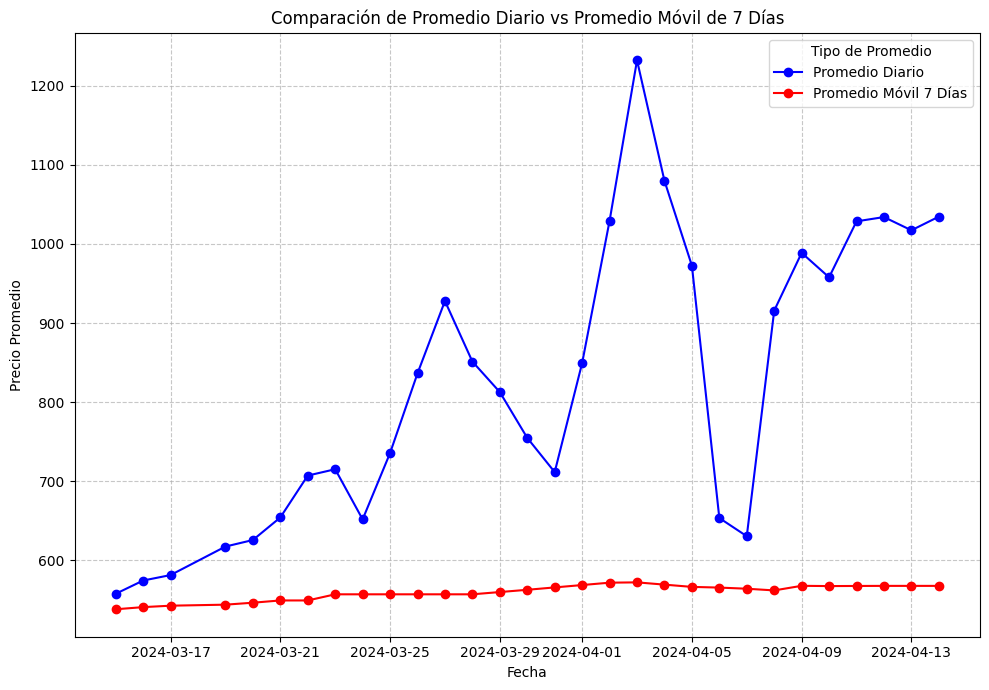

In [15]:
# Creación gráfica
plt.figure(figsize=(10, 7))
plt.plot(promedios_por_fecha['fecha'], promedios_por_fecha['precio_promedio'], label='Promedio Diario', color='blue', marker='o')
plt.plot(promedios_por_fecha['fecha'], promedios_por_fecha['precio_7d'], label='Promedio Móvil 7 Días', color='red',  marker='o')

plt.title('Comparación de Promedio Diario vs Promedio Móvil de 7 Días')
plt.xlabel('Fecha', fontsize = 10)
plt.ylabel('Precio Promedio',fontsize = 10)
plt.legend(title='Tipo de Promedio')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout() 
# Almacenar la gráfica como 'image.png'
plt.savefig('image.png')
plt.show()

<h3>Análisis Rápido del Comportamiento de los Datos</h3>

<p>
<b>Promedio Diario:</b> Los datos visualizados muestran cómo varía el precio promedio para cada fecha, presentando fluctuaciones de mayor a menor escala según el período. Un ejemplo de esto es el precio más alto registrado en todas las fechas, aproximadamente 1200, correspondiente al período entre el 2024-04-01 y el 2024-04-05. En solo 4 días, el valor pasó de tener un valor medio a uno anormalmente alto. 
</p>
<p>
<b>Promedio Móvil de 7 Días:</b> Estos datos permiten obtener una visión más clara del comportamiento general durante ese intervalo de tiempo, mostrando la tendencia general del precio y suavizando los picos y valles.
</p>



### Almacenamiento de Resultados 

In [16]:
# Convertir la columna 'fecha' a string en formato YYYY-MM-DD 
promedios_por_fecha['fecha'] = promedios_por_fecha['fecha'].dt.strftime('%Y-%m-%d')

In [17]:
try:
    # Conexión a la base de datos (se crea en el directorio actual)
    db_filename = 'precios.sqlite'
    print(f"Conectando a la base de datos en: {db_filename}")
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()

    # Eliminar la tabla si ya existe (para sobreescribirla)
    cursor.execute('DROP TABLE IF EXISTS Precios')

    # Creación de la tabla contratos
    cursor.execute('''
    CREATE TABLE precios (
        fecha DATETIME,     
        precio_promedio FLOAT,
        precio_7d  FLOAT
    );
    ''')

    # Convertir el DataFrame a una lista de tuplas, asegurándose de que solo se incluyan las columnas necesarias
    datos_precios = list(promedios_por_fecha[['fecha', 'precio_promedio', 'precio_7d']].itertuples(index=False, name=None))

    # Insertar los datos en la tabla precios
    cursor.executemany("INSERT INTO precios (fecha, precio_promedio, precio_7d) VALUES (?,?,?)", datos_precios)

    # Confirmar y cerrar la conexión
    conn.commit()
    conn.close()

    print("Datos insertados y tabla creada correctamente.")

except sqlite3.OperationalError as e:
    print(f"Error de operación de SQLite: {e}")
except Exception as e:
    print(f"Error general: {e}")


Conectando a la base de datos en: precios.sqlite
Datos insertados y tabla creada correctamente.
